# DCGAN

- paper : https://arxiv.org/abs/1511.06434
- implementation : https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html

In [1]:
import os
import shutil

import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

import torchvision
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms
from torchvision.utils import make_grid

import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
from PIL import Image

import time

torch.manual_seed(999)

In [2]:
datadir = "data/celeba"
savedir = "result/dcgan"
workers = 2
epochs = 20
batch_size = 256
image_size = 128
nc = 3 # num of channels
nz = 100  # size of z latent vector (= size of generator input)
ngf = 128 # size of feature maps in generator
ndf = 128 # size of feature maps in discriminator
lr = 0.0002
beta1 = 0.5  # hyperparameter for adam optimizer (momentum)
image_list_freq = 500
device = "cuda"
indent = '   '

## Dataset

In [3]:
for hiddendir in [x for x in os.listdir(datadir) if os.path.isdir(os.path.join(datadir, x)) and x.startswith(".")]:
    shutil.rmtree(os.path.join(datadir, hiddendir))

dataset = ImageFolder(root=datadir, transform=transforms.Compose([
    transforms.Resize(image_size),
    transforms.CenterCrop(image_size),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
]))

dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=workers)

### Image preview

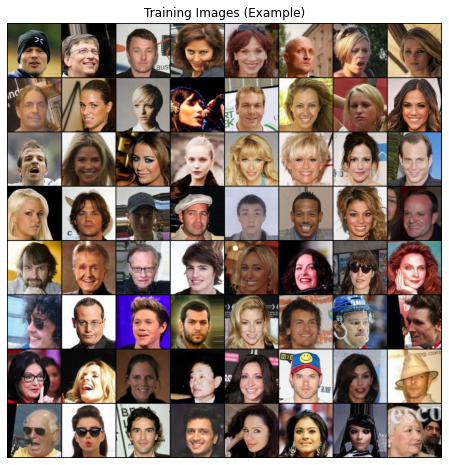

In [4]:
batch = next(iter(dataloader))
plt.figure(figsize=(8, 8))
plt.axis("off")
plt.title("Training Images (Example)")
plt.imshow(np.transpose(make_grid(batch[0][:64], padding=2, normalize=True).cpu(), (1, 2, 0)))

## Models : Generator, Discriminator

In [5]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.blocks = nn.Sequential(
            self._block(
                in_channels=nz,
                out_channels=ngf * 16,
                kernel_size=4,
                stride=1,
                padding=0
            ),
            self._block(
                in_channels=ngf * 16,
                out_channels=ngf * 8,
                kernel_size=4,
                stride=2,
                padding=1
            ),
            self._block(
                in_channels=ngf * 8,
                out_channels=ngf * 4,
                kernel_size=4,
                stride=2,
                padding=1
            ),
            self._block(
                in_channels=ngf * 4,
                out_channels=ngf * 2,
                kernel_size=4,
                stride=2,
                padding=1
            ),
            self._block(
                in_channels=ngf * 2,
                out_channels=ngf,
                kernel_size=4,
                stride=2,
                padding=1
            ),
            self._last_block(
                in_channels=ngf,
                out_channels=nc,
                kernel_size=4,
                stride=2,
                padding=1
            )
        )
        
    def _block(self, in_channels, out_channels, kernel_size, stride, padding, bias=False):
        return nn.Sequential(
            nn.ConvTranspose2d(
                in_channels=in_channels,
                out_channels=out_channels,
                kernel_size=kernel_size,
                stride=stride,
                padding=padding,
                bias=bias
            ),
            nn.BatchNorm2d(
                num_features=out_channels
            ),
            nn.ReLU(
                inplace=True
            )
        )
    
    def _last_block(self, in_channels, out_channels, kernel_size, stride, padding, bias=False):
        return nn.Sequential(
            nn.ConvTranspose2d(
                in_channels=in_channels,
                out_channels=out_channels,
                kernel_size=kernel_size,
                stride=stride,
                padding=padding,
                bias=bias
            ),
            nn.Tanh()
        )
    
    def forward(self, x):
        # x : [batch, channel, h, w] = [batch, nz=100, 1, 1]
        # block1_result : [batch, channel, h, w] = [batch, ngf*8=512, 4, 4]
        # block2_result : [batch, channel, h, w] = [batch, ngf*4=256, 8, 8]
        # block3_result : [batch, channel, h, w] = [batch, ngf*2=128, 16, 16]
        # block4_result : [batch, channel, h, w] = [batch, ngf=64, 32, 32]
        # block5_result : [batch, channel, h, w] = [batch, nc=3, 64, 64]
        return self.blocks(x)

In [6]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.blocks = nn.Sequential(
            self._first_block(
                in_channels=nc,
                out_channels=ndf,
                kernel_size=4,
                stride=2,
                padding=1
            ),
            self._block(
                in_channels=ndf,
                out_channels=ndf * 2,
                kernel_size=4,
                stride=2,
                padding=1
            ),
            self._block(
                in_channels=ndf * 2,
                out_channels=ndf * 4,
                kernel_size=4,
                stride=2,
                padding=1
            ),
            self._block(
                in_channels=ndf * 4,
                out_channels=ndf * 8,
                kernel_size=4,
                stride=2,
                padding=1
            ),
            self._block(
                in_channels=ndf * 8,
                out_channels=ndf * 16,
                kernel_size=4,
                stride=2,
                padding=1
            ),
            self._last_block(
                in_channels=ndf * 16,
                out_channels=1,
                kernel_size=4,
                stride=1,
                padding=0
            )
        )
        
    def _first_block(self, in_channels, out_channels, kernel_size, stride, padding, bias=False):
        return nn.Sequential(
            nn.Conv2d(
                in_channels=in_channels,
                out_channels=out_channels,
                kernel_size=kernel_size,
                stride=stride,
                padding=padding,
                bias=bias                
            ),
            nn.LeakyReLU(
                negative_slope=0.2,
                inplace=True
            )
        )
    
    def _block(self, in_channels, out_channels, kernel_size, stride, padding, bias=False):
        return nn.Sequential(
            nn.Conv2d(
                in_channels=in_channels,
                out_channels=out_channels,
                kernel_size=kernel_size,
                stride=stride,
                padding=padding,
                bias=bias                
            ),
            nn.BatchNorm2d(
                num_features=out_channels
            ),
            nn.LeakyReLU(
                negative_slope=0.2,
                inplace=True
            )
        )
    
    def _last_block(self, in_channels, out_channels, kernel_size, stride, padding, bias=False):
        return nn.Sequential(
            nn.Conv2d(
                in_channels=in_channels,
                out_channels=out_channels,
                kernel_size=kernel_size,
                stride=stride,
                padding=padding,
                bias=bias                
            ),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        # x : [batch, channel, h, w] = [batch, nc=3, 64, 64]
        # block1_result : [batch, channel, h, w] = [batch, ndf=64, 32, 32]
        # block2_result : [batch, channel, h, w] = [batch, ndf*2=128, 16, 16]
        # block3_result : [batch, channel, h, w] = [batch, ndf*4=256, 8, 8]
        # block4_result : [batch, channel, h, w] = [batch, ndf*8=512, 4, 4]
        # block5_result : [batch, channel, h, w] = [batch, 1, 1, 1]
        return self.blocks(x)

## Training

In [7]:
def init_weights(module):
    classname = module.__class__.__name__
    if classname.find("Conv") != -1:
        nn.init.normal_(module.weight.data, 0.0, 0.02)
    elif classname.find("BatchNorm") != -1:
        nn.init.normal_(module.weight.data, 1.0, 0.02)
        nn.init.constant_(module.bias.data, 0)

In [8]:
netG = Generator().to(device)
netG.apply(init_weights)
print(netG)

netD = Discriminator().to(device)
netD.apply(init_weights)
print(netD)

Generator(
  (blocks): Sequential(
    (0): Sequential(
      (0): ConvTranspose2d(100, 2048, kernel_size=(4, 4), stride=(1, 1), bias=False)
      (1): BatchNorm2d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): ConvTranspose2d(2048, 1024, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (2): Sequential(
      (0): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (3): Sequential(
      (0): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU

In [9]:
criterion = nn.BCELoss()

fixed_noise = torch.randn(64, nz, 1, 1).to(device)

REAL_LABEL = 1
FAKE_LABEL = 0

optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

In [ ]:
img_list = []
G_losses = []
D_losses = []
iters = 0

for epoch in range(epochs):
    epoch_start_time = time.time()
    print(f"Epoch {epoch + 1:3}/{epochs:3}")
    
    epoch_G_loss = 0
    epoch_D_loss = 0
    
    for i, data in enumerate(dataloader):
        batch_start_time = time.time()
        
        # 1. Update D : maximize log(D(x)) + log(1 - D(G(z)))
        netD.zero_grad()
        
        ## Train with all-real batch
        real_examples = data[0].to(device)
        real_labels = torch.full((real_examples.shape[0],), REAL_LABEL).float().to(device)
        
        real_output = netD(real_examples).flatten()
        real_loss = criterion(real_output, real_labels)
        real_loss.backward()

        D_x = real_output.mean().item()
        
        ## Train with all-fake batch
        zs = torch.randn(batch_size, nz, 1, 1).to(device)
        fake_examples = netG(zs)
        fake_labels = torch.full((fake_examples.shape[0],), FAKE_LABEL).float().to(device)
        
        fake_output = netD(fake_examples.clone().detach()).flatten()
        fake_loss = criterion(fake_output, fake_labels)
        fake_loss.backward()
        
        D_G_z1 = fake_output.mean().item()
        
        ## update D params
        D_loss = real_loss + fake_loss
        optimizerD.step()
        
        # 2. Update G : maximize log(G(D(z)))
        netG.zero_grad()
        
        G_labels = torch.full((fake_examples.shape[0],), REAL_LABEL).float().to(device)
        
        G_output = netD(fake_examples).flatten()
        G_loss = criterion(G_output, G_labels)
        G_loss.backward()
        
        D_G_z2 = G_output.mean().item()
        
        ## update G params
        optimizerG.step()
        
        # 3. Etc
        ## print logs
        if i % 50 == 0:
            print(f'{indent * 2}Iter {i:4}/{len(dataloader):4} [{time.time() - batch_start_time:.4f}s] \t D_loss: {D_loss.item():8.4f} | G_loss: {G_loss.item():8.4f} | D(x): {D_x:8.4f} | D(G(z)): {D_G_z1:8.4f} / {D_G_z2:8.4f}')

        ## save losses for plotting later
        G_losses.append(G_loss.item())
        D_losses.append(D_loss.item())
        epoch_G_loss += G_loss.item()
        epoch_D_loss += D_loss.item()

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % image_list_freq == 0) or ((epoch == epochs - 1) and (i == len(dataloader) - 1)):
            with torch.no_grad():
                fake_examples = netG(fixed_noise).detach().cpu()
            img_list.append(make_grid(fake_examples, padding=2, normalize=True))
        iters += 1
    
    epoch_elapsed_time = time.time() - epoch_start_time
    print(f"{indent}D_loss: {epoch_D_loss / len(dataloader):8.4f} [{epoch_elapsed_time // 60}m {epoch_elapsed_time % 60:.4f}s] \tG_loss: {epoch_G_loss / len(dataloader):8.4f}")

Epoch   1/ 20
      Iter    0/ 792 [1.7162s] 	 D_loss:   3.3427 | G_loss:  52.1026 | D(x):   0.6825 | D(G(z)):   0.8140 /   0.0000
      Iter   50/ 792 [1.6572s] 	 D_loss: 100.0000 | G_loss:   0.0000 | D(x):   1.0000 | D(G(z)):   1.0000 /   1.0000
      Iter  100/ 792 [1.6484s] 	 D_loss: 100.0000 | G_loss:   0.0000 | D(x):   1.0000 | D(G(z)):   1.0000 /   1.0000
      Iter  150/ 792 [1.6509s] 	 D_loss: 100.0000 | G_loss:   0.0000 | D(x):   1.0000 | D(G(z)):   1.0000 /   1.0000
      Iter  200/ 792 [1.6513s] 	 D_loss: 100.0000 | G_loss:   0.0000 | D(x):   1.0000 | D(G(z)):   1.0000 /   1.0000
      Iter  250/ 792 [1.6565s] 	 D_loss: 100.0000 | G_loss:   0.0000 | D(x):   1.0000 | D(G(z)):   1.0000 /   1.0000
      Iter  300/ 792 [1.6545s] 	 D_loss: 100.0000 | G_loss:   0.0000 | D(x):   1.0000 | D(G(z)):   1.0000 /   1.0000
      Iter  350/ 792 [1.6557s] 	 D_loss: 100.0000 | G_loss:   0.0000 | D(x):   1.0000 | D(G(z)):   1.0000 /   1.0000
      Iter  400/ 792 [1.6553s] 	 D_loss: 100.0000 

## Result

In [ ]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())

In [ ]:
!mkdir -p {savedir}

with torch.no_grad():
    fake_examples = np.transpose(netG(fixed_noise).detach().cpu().numpy(), (0, 2, 3, 1))
    for i, example in enumerate(fake_examples, 1):
        Image.fromarray((example * 255).astype(np.uint8)).save(os.path.join(savedir, f"dcgan-{i:02d}.png"))